In [ ]:
%load_ext jupyter_black

# Benchmarking an algorithm for MAX-k-SAT

We showcase qubrabench by implementing and benchmarking a hillclimbing algorithm for MAX-k-SAT, described in https://arxiv.org/abs/2203.04975.
The paper describes two variants: a normal hillclimber - which uses (quantum) search, and a steep one - which use (quantum) max finding.

## Problem: MAX-k-SAT

Max-k-SAT is a combinatorial optimization problem that given a list of clauses $(C_{i})^{p}_{i=1}$, each a disjunction of at most $k$ literals, and a set of weights $(w_{i})^{p}_{i=1}$, asks us to maximize the weight of the satisfied clauses,
$$\varphi(y) := \sum ^{p} _{i=1} w_{i}C_{i}(y),$$
over all assignments $y \in \{0, 1\}^{q}$ of the variables. This problem is NP-hard for $k ≥ 2$.

## Algorithm: Hillclimb search

We start with a random assignment $y \in \{0, 1\}^{n}$ and look for improvements in the set of all bitstrings that differ from $y$ in at most $d$ bits.
The simple hill climber randomly samples such assignments until it finds one with a strictly higher value of $\varphi$, which is then taken as the new assignment.
This procedure is repeated until no further improvement is found.
We can formalize each hillclimb step (described above) as searching for a solution in
$$f:N_{d}(y) \subseteq \{0,1\}^{n} →\{0,1\}$$
$$f(z) = \begin{cases}1 ~~~~~\text{if}~ \varphi(z)>\varphi(y)\\ 0 ~~~~~\text{otherwise} \end{cases}$$

In [4]:
import numpy as np
import pandas as pd

In [3]:
%psource hill_climber

def hill_climber(
    inst: WeightedSatInstance,
    *,
    rng: np.random.Generator,
    error: Optional[float] = None,
    stats: Optional[QueryStats] = None,
    steep: bool = False,
) -> Optional[Assignment]:
    """A hillclimbing heuristic to find maximizing assignments to weighted SAT instances
        by progressively transitioning to better solutions using neighborhood search.


    Args:
        inst: The SAT instance to be solved.
        rng: Source of randomness
        error: upper bound on the failure probability. Defaults to None.
        stats: Statistics instance keeping track of costs. Defaults to None.
        steep: True when the neighborhood search is performed greedily, otherwise randomly. Defaults to False.

    Returns:
        Optional[Assignment]: The best assignment found by the heuristic.
    """
    if rng is None:
        rng = np.random.default_rng()

    # precompute some matrices (see 4.3.2 in Cade et al)
    n = inst.n
    ones = np.ones(n, dtype=int)


We can take a look at the $search$ and $max$ functions used above.

In [4]:
from qubrabench.algorithms.search import search as qsearch

%pdoc qsearch

Class docstring:
    Search a list in random order for an element satisfying the given predicate, while keeping track of query statistics.
    
    >>> search([1,2,3,4,5], lambda x: x % 2 == 0, rng=np.random.default_rng(1))
    2
    
    Args:
        iterable: iterable to be searched over
        key: function to test if an element satisfies the predicate
        rng: np.random.Generator instance as source of randomness
        error: upper bound on the failure probability of the quantum algorithm.
        max_classical_queries: maximum number of classical queries before entering the quantum part of the algorithm.
        stats: keeps track of statistics.
    
    Raises:
        ValueError: Raised when the error bound is not provided and statistics cannot be calculated.
    
    Returns:
        An element that satisfies the predicate, or None if no such argument can be found.
Call docstring:
    Call self as a function.

In [5]:
from qubrabench.algorithms.max import max as qmax

%pdoc qmax

Class docstring:
    Find the largest element in a list, while keeping track of query statistics.
    
    Args:
        iterable: iterable to find the maximum in
        default: default value to return if iterable is empty.
        key: function that maps iterable elements to values that are comparable. By default, use the iterable elements.
        error: upper bound on the failure probability of the quantum algorithm.
        stats: object that keeps track of statistics.
    
    Raises:
        ValueError: Raised when the failure rate `error` is not provided and statistics cannot be calculated.
        ValueError: Raised when iterable is an empty sequence and no default is provided.
    
    Returns:
        the desired maximum element
Call docstring:
    Call self as a function.

## Benchmarking

The imported `run` function executes the hillclimber on a random instance and returns the statistics in a pandas DataFrame.

In [6]:
%pdoc run

Class docstring:
    External interface to generate weighted sat instances, run the hillclimber algorithm and return statistics.
    
    Args:
        k: Number of literals in a clause
        r: Factor for the number of clauses
        n: size (variable number) of the SAT instances
        n_runs: number of runs to perform in each group
        rng: Source of randomness
        error: Upper bound on the failure rate. Defaults to None.
        random_weights: Optionally providable weights for SAT instance generation. Defaults to None.
        steep: Whether to perform hillclimb steep (greedily). Defaults to False.
    
    Returns:
        Dataframe holding benchmarking statistics of the runs performed.
Call docstring:
    Call self as a function.

Let's run the simple hill climber for $n = 100$, $n = 300$ and $n=1000$. We will run the hill climber five times for each $n$ and consistently use $k = 3$.

In [7]:
%%time
data_100 = run(
    k=3,
    r=3,
    n=100,
    n_runs=5,
    rng=np.random.default_rng(seed=100),
    error=10**-5,
    steep=False,
)
data_100

CPU times: user 507 ms, sys: 1.56 s, total: 2.07 s
Wall time: 153 ms


,classical_control_method_calls,classical_actual_queries,classical_expected_queries,quantum_expected_classical_queries,quantum_expected_quantum_queries,n,k,r
0,34,275,341.065934,404.881635,1384.042495,100,3,3
1,39,473,445.956675,546.931407,1406.459959,100,3,3
2,49,813,709.188631,920.493066,1486.303359,100,3,3
3,43,471,386.570526,465.600523,1402.465719,100,3,3
4,22,349,340.424143,431.042073,1406.301255,100,3,3


In [8]:
%%time
data_300 = run(
    k=3,
    r=3,
    n=300,
    n_runs=5,
    rng=np.random.default_rng(seed=100),
    error=10**-5,
    steep=False,
)
data_300

CPU times: user 4.36 s, sys: 9.47 s, total: 13.8 s
Wall time: 1.07 s


,classical_control_method_calls,classical_actual_queries,classical_expected_queries,quantum_expected_classical_queries,quantum_expected_quantum_queries,n,k,r
0,97,1490,1530.514352,1351.690211,2680.479146,300,3,3
1,104,1847,1495.262898,1303.858463,2690.706632,300,3,3
2,114,1289,1477.074700,1279.210218,2691.116070,300,3,3
3,115,1749,1556.280257,1307.311720,2768.560829,300,3,3
4,132,2007,1925.946128,1756.475075,2710.741974,300,3,3


In [9]:
%%time
data_500 = run(
    k=3,
    r=3,
    n=500,
    n_runs=5,
    rng=np.random.default_rng(seed=100),
    error=10**-5,
    steep=False,
)
data_500

CPU times: user 18.9 s, sys: 47.5 s, total: 1min 6s
Wall time: 4.73 s


,classical_control_method_calls,classical_actual_queries,classical_expected_queries,quantum_expected_classical_queries,quantum_expected_quantum_queries,n,k,r
0,180,2944,2835.450715,2289.638194,3764.294014,500,3,3
1,176,2652,2783.501729,2167.874466,3792.974281,500,3,3
2,197,3325,3097.640959,2572.725882,3744.963669,500,3,3
3,191,2822,3034.755582,2389.933505,3825.687399,500,3,3
4,194,3080,3077.856689,2536.786571,3760.542570,500,3,3


## Plotting
We use the `PlottingStrategy` wrapper to define our plot parameters and configuration.

In [10]:
from qubrabench.utils.plotting_strategy import PlottingStrategy


class Plotter(PlottingStrategy):
    def __init__(self):
        self.colors[""] = "blue"

    def get_plot_group_column_names(self):
        return ["k", "r"]

    def get_data_group_column_names(self):
        return []

    def compute_aggregates(self, data, *, quantum_factor):
        # compute combined query costs of quantum search
        c = data["quantum_expected_classical_queries"]
        q = data["quantum_expected_quantum_queries"]
        data["quantum_cost"] = c + quantum_factor * q
        return data

    def x_axis_column(self):
        return "n"

    def x_axis_label(self):
        return "$n$"

    def y_axis_label(self):
        return "Queries"

    def get_column_names_to_plot(self):
        return {
            "classical_actual_queries": ("Classical Queries", "o"),
            "quantum_cost": ("Quantum Queries", "x"),
        }

We can put all the benchmark stats in a single table and run the plotter. 

In [11]:
%pdoc Plotter.plot

Class docstring:
    Plot benchmarking data.
    
    Args:
        data: a pandas DataFrame containing all the benchmark data.
        quantum_factor: conversion factor for the cost of a quantum query (w.r.t. classical queries).
        y_lower_lim: lower limit on the Y-axis (useful if the data starts at a large value)
    
    Raises:
        ValueError: if no columns are given to plot
Call docstring:
    Call self as a function.

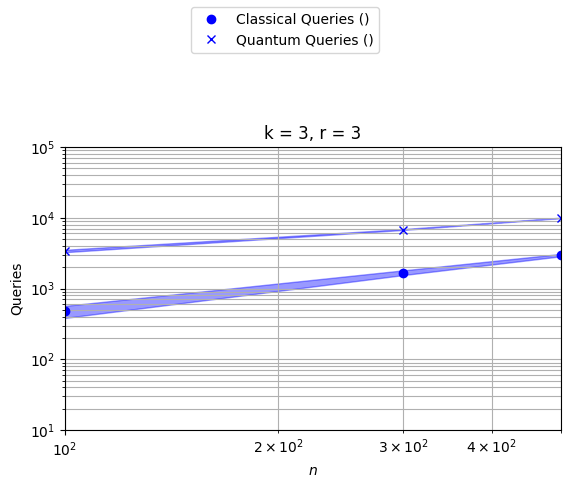

In [12]:
data = pd.concat([data_100, data_300, data_500])
Plotter().plot(data, quantum_factor=2, y_lower_lim=10)

Now we can also run the "steep" hillclimber for the above instance sizes, and compare the two benchmarks.

In [13]:
%%time
data_steep = [
    run(
        k=3,
        r=3,
        n=n,
        n_runs=5,
        rng=np.random.default_rng(seed=100),
        error=10**-5,
        steep=True,
    )
    for n in [100, 300, 500]
]
data_steep = pd.concat(data_steep)

CPU times: user 17 s, sys: 40.6 s, total: 57.7 s
Wall time: 3.65 s


In [14]:
# add an extra column to distinguish the source (i.e. type of hillclimb)
full_data = []
for d, is_steep in [(data, False), (data_steep, True)]:
    d = d.copy()
    d.insert(0, "steep", is_steep)
    full_data.append(d)
full_data = pd.concat(full_data)

We modify the above plotter a bit as we now want to group the data by column "steep" (in the same plot).

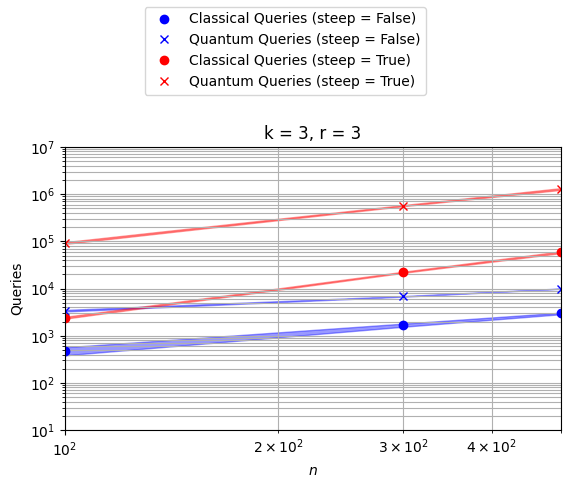

In [15]:
class FullPlotter(Plotter):
    def __init__(self):
        self.colors["steep = False"] = "blue"
        self.colors["steep = True"] = "red"

    def get_data_group_column_names(self):
        return ["steep"]


FullPlotter().plot(full_data, quantum_factor=2, y_lower_lim=10)